## Import dependencies

In [98]:
# compute
import numpy as np
import numpy.matlib
import pandas as pd

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# stats
#import pycircstat as pyc
from scipy import stats

# plot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 

# spykes
from neuropop import NeuroPop
from neurovis import NeuroVis

# local
import V4pyutils

colors=['#F5A21E', '#134B64', '#EF3E34', '#02A68E', '#FF07CD']
color_data_art = colors[1]
color_data_nat = colors[2]
color_model_art = colors[0]
color_model_nat = colors[0]

# Objective: predict neural activity for natural scenes

## Experimental details

### Artificial stimuli

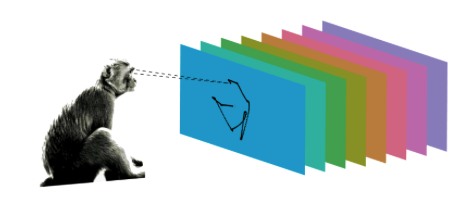

In [20]:
Image(filename="../Figures/experiment_artificial.png", width=400)

### Natural Stimuli

In [19]:
Image(filename="../Figures/experiment_natural.png", width=300)

## why is this interesting?


### sort of dashboard with some preliminary analysis

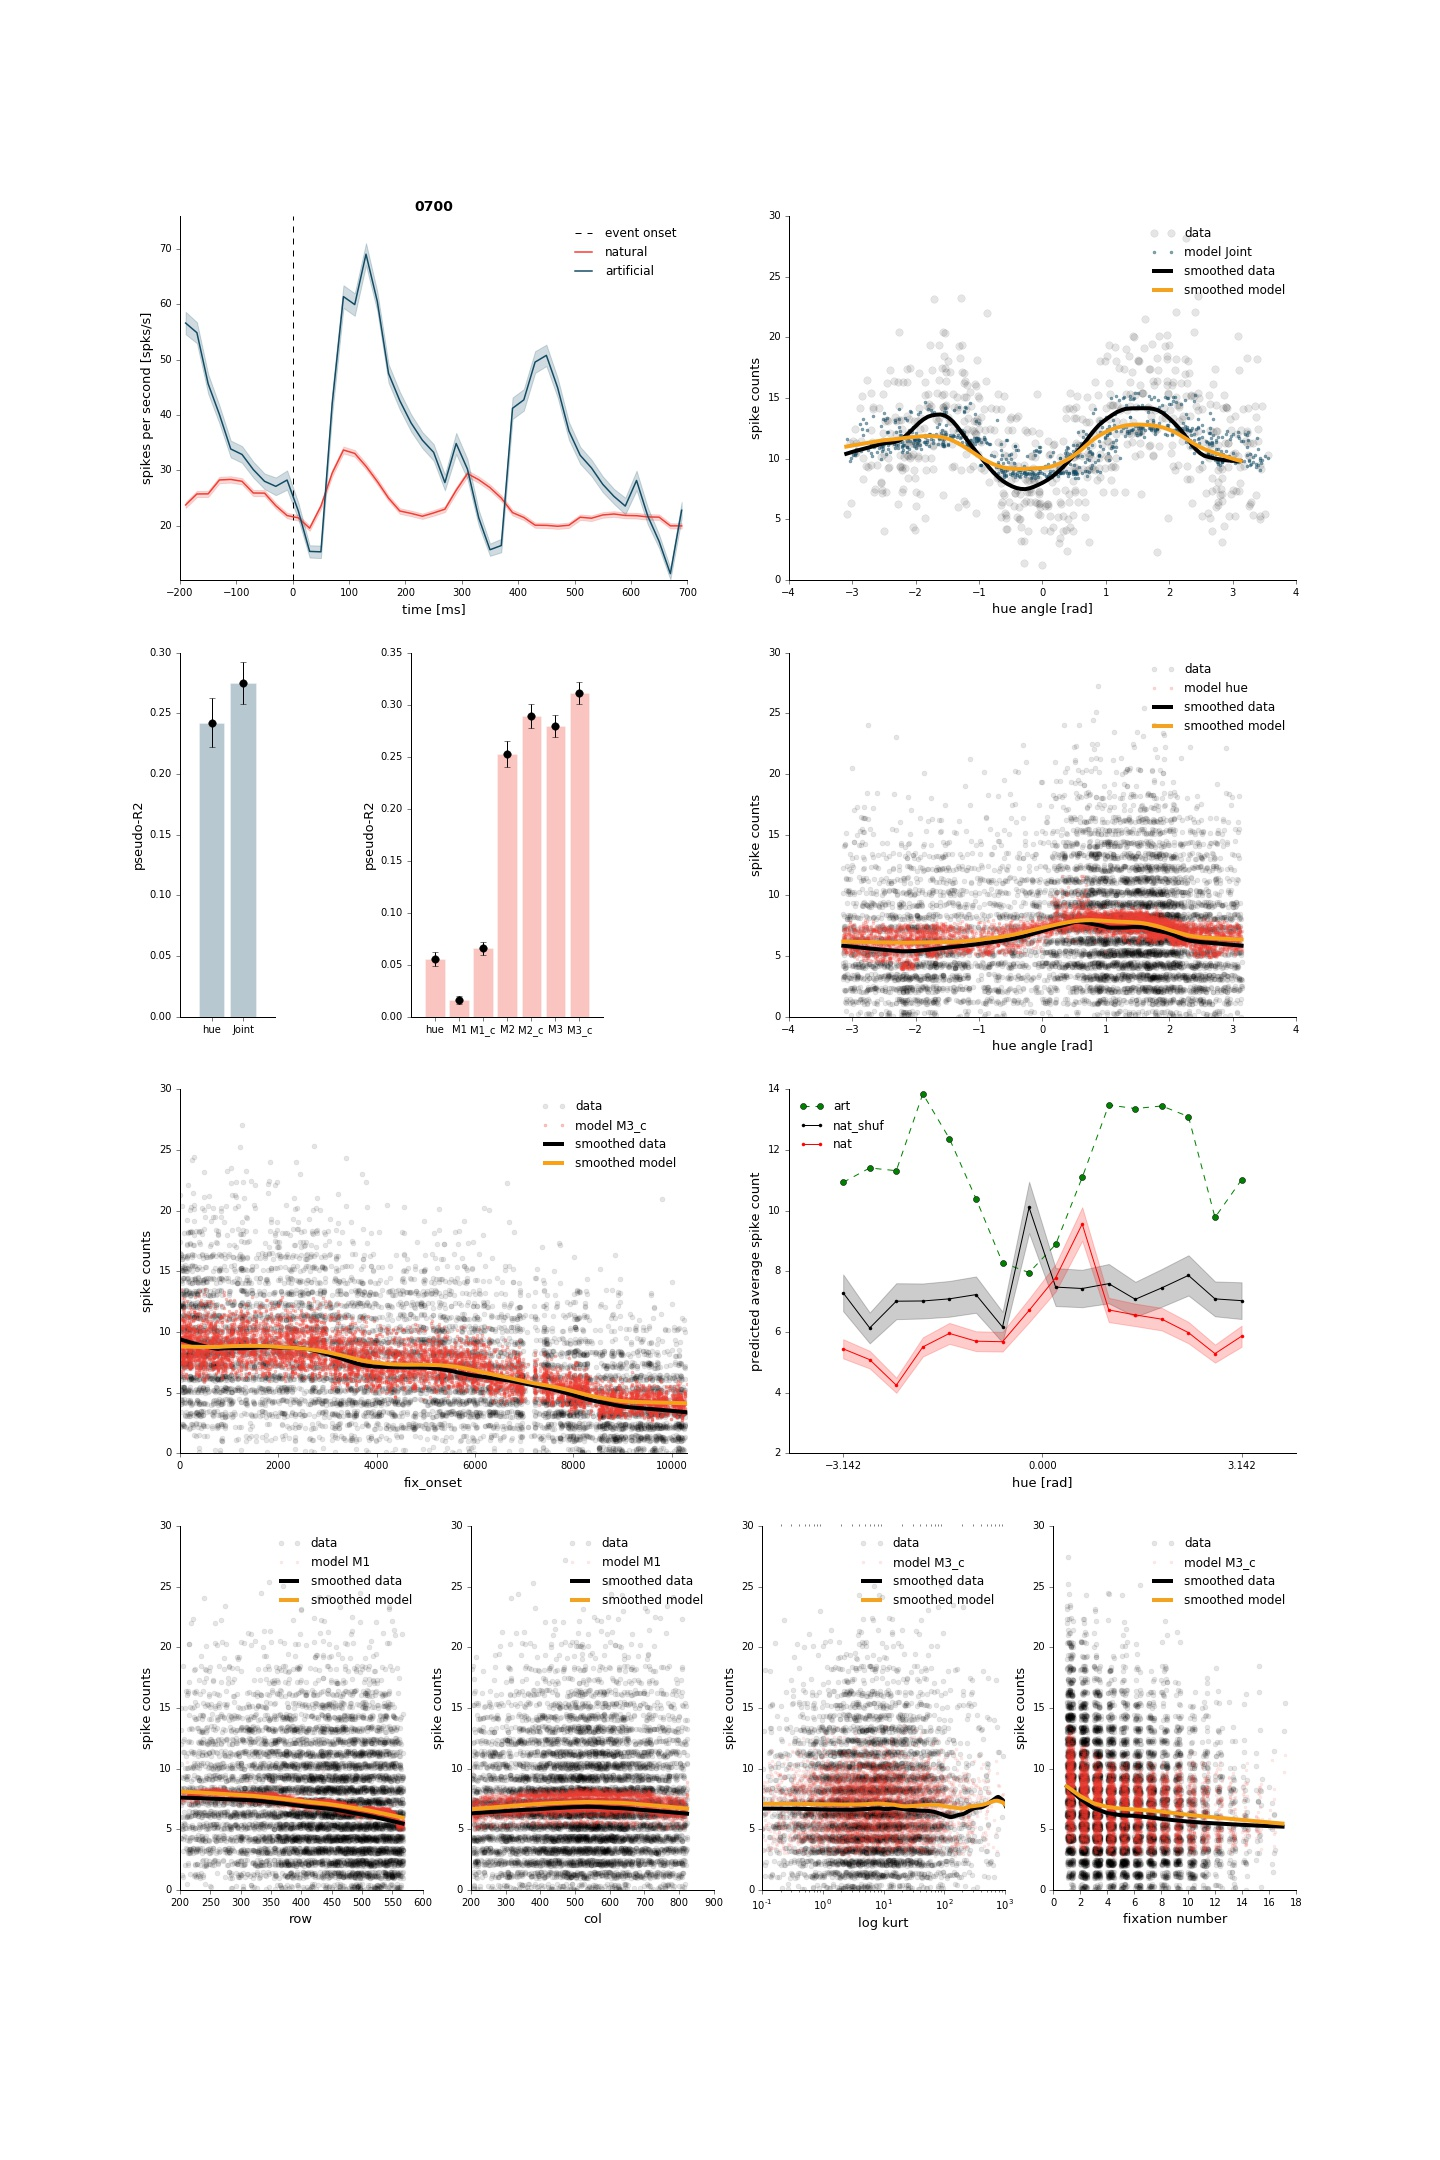

In [33]:
Image(filename="../Figures/dash_board_0700.jpg", width=600)

## Read in files

### List files

In [2]:
h5path = '../V4pydata/H5data/M3/'
fname = glob.glob(h5path+'/*89a*')
fname
glob.glob(h5path+'/*89a*')

['../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5_imagefeatures_wip',
 '../V4pydata/H5data/M3/Ro150212_289a_huecircle_0003_nev.h5',
 '../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5',
 '../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev_imagefeatures_wip.h5']

### Artificial

In [3]:
# Read using deepdish
art_file = fname[1]
print art_file
art_dat = dd.io.load(art_file)

../V4pydata/H5data/M3/Ro150212_289a_huecircle_0003_nev.h5


### Natural

In [4]:
# Read using deepdish
nat_file = fname[2]
print nat_file
nat_dat = dd.io.load(nat_file)

../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5


### Sanity check: compare firing rates for artificial vs. natural

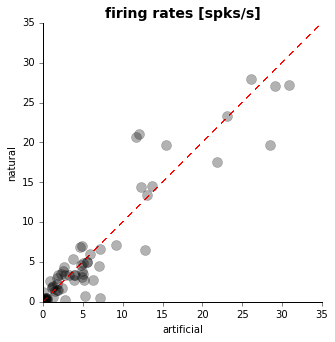

In [27]:
# Artificial
art_rates = dict()
for neuron_id in art_dat['spikes']:
    art_rates[neuron_id]=V4pyutils.get_firing_rate(art_dat['spikes'][neuron_id])

# Natural
nat_rates = dict()
for neuron_id in nat_dat['spikes']:
    nat_rates[neuron_id]=V4pyutils.get_firing_rate(nat_dat['spikes'][neuron_id])

# Plot artificial vs. natural firing rates
plt.figure(figsize=(5,5))
for i in art_rates:
    plt.plot([0,35],[0,35],'--r', lw=0.1)
    plt.plot(art_rates[i], nat_rates[i],'ko', alpha=0.3, ms=10)
    plt.xlabel('artificial')
    plt.ylabel('natural')
    plt.title('firing rates [spks/s]')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')
    plt.axis('equal')
plt.show()

## Get features (X)

In [22]:
params = dict()
params['n_bins'] = 16 #number of bins of the histogram
params['window'] = [50, 300] #
params['radius'] = 200
params['n_patches'] = 16 #for natural stimuli
params['n_blocks'] = np.int(np.sqrt(params['n_patches']))
params['stimpath'] = '../V4pydata'

### artificial features

In [23]:
# Collect features of interest into a dict
features_art = dict()
features_art['col'] = np.array([art_dat['eyes'][i]['col'] for i in art_dat['eyes']])
features_art['row'] = np.array([art_dat['eyes'][i]['col'] for i in art_dat['eyes']])
features_art['hue'] = np.array([art_dat['features'][i]['hue'] for i in art_dat['features']])
features_art['onset_times'] = np.array([art_dat['events'][i]['onset'] for i in art_dat['events']])
features_art['offset_times'] = np.array([art_dat['events'][i]['offset'] for i in art_dat['events']])

# DataFrame
features_art_df = pd.DataFrame.from_dict(features_art, orient='columns', dtype=None)

# add some more features
features_art_df['off_to_onset_times'] = features_art['onset_times']-np.roll(features_art['offset_times'],1)
features_art_df['off_to_onset_times'][0] = -999.0

features_art_df['hue_prev'] = np.roll(features_art['hue'], 1)
features_art_df['hue_prev'][0] = -999.0

features_art_df['stim_dur'] = features_art_df['offset_times']-features_art_df['onset_times']

# sort columns
cols = features_art_df.columns.tolist()

new_order = ['onset_times', 'offset_times', 'col', 'row', 
             'hue', 'hue_prev', 'stim_dur', 'off_to_onset_times']

features_art_df = features_art_df[new_order]

features_art_df.head()

onset_times  offset_times    col    row       hue    hue_prev  stim_dur  \
0    66.106033     66.308333  368.0  368.0  1.822645 -999.000000  0.202300   
1    66.435933     66.633233  366.0  366.0 -0.131535    1.822645  0.197300   
2    66.746033     66.947067  367.0  367.0  1.609290   -0.131535  0.201033   
3    67.070933     67.272667  376.0  376.0  1.250616    1.609290  0.201733   
4    69.508967     69.726167  366.0  366.0  3.125854    1.250616  0.217200   

   off_to_onset_times  
0         -999.000000  
1            0.127600  
2            0.112800  
3            0.123867  
4            2.236300

In [24]:
# Encode hue histogram as one-hot vector (sort of)
Xart = V4pyutils.onehothue(features_art_df['hue'], n_bins=params['n_bins'])

### natural features

#### non-visual

In [25]:
for_features_nat = nat_dat['eyes'][0].keys()
for i in ['imname','impath']: for_features_nat.remove(i) 

features_nat = dict()
for feat in for_features_nat:
    features_nat[feat] = np.array([nat_dat['eyes'][fix][feat] for fix in nat_dat['eyes']]) 

In [26]:
features_nat_df = pd.DataFrame(features_nat)
features_nat_df['badfix'] = features_nat_df['badfix']==0
features_nat_df['in_sac_blink'] = features_nat_df['in_sac_blink']==1
features_nat_df['out_sac_blink'] = features_nat_df['out_sac_blink']==1

features_nat_df['fix_duration'] = features_nat_df['fix_offset'] - features_nat_df['fix_onset']
features_nat_df['next_fix_duration'] = np.append(features_nat_df['fix_duration'][1:], 0)
features_nat_df['prev_fix_duration'] = np.append(0, features_nat_df['fix_duration'][0:-1])
features_nat_df['in_screen'] = np.all((features_nat_df['col']>=1, features_nat_df['col']<=1024, \
                                features_nat_df['row']>=1, features_nat_df['row']<=768), axis=0)
features_nat_df['row_drift'] = features_nat_df['fix_offset_row']-features_nat_df['fix_onset_row']
features_nat_df['col_drift'] = features_nat_df['fix_offset_col']-features_nat_df['fix_onset_col']
features_nat_df['drift'] = np.abs(features_nat_df['row_drift'])+np.abs(features_nat_df['col_drift'])

# sort columns
cols = features_nat_df.columns.tolist()
cols = ['trial', 'fixation', 'fix_onset', 'fix_offset', 'row', 'col',
        'fix_onset_row', 'fix_onset_col', 'fix_offset_row', 'fix_offset_col',
        'in_sac_blink', 'in_sac_dur', 'in_sac_pkvel',
        'out_sac_blink', 'out_sac_dur', 'out_sac_pkvel',
        'fix_duration','prev_fix_duration', 'next_fix_duration',
        'row_drift', 'col_drift', 'drift',
        'in_screen', 'badfix']

features_nat_df = features_nat_df[cols]

features_nat_df.head()

trial  fixation  fix_onset  fix_offset    row    col  fix_onset_row  \
0      1         1      2.230       2.557  425.0  578.0          434.0   
1      1         2      2.596       2.779  499.0  597.0          489.0   
2      1         3      2.832       2.945  678.0  310.0          676.0   
3      1         4      2.996       3.826  460.0   82.0          469.0   
4      1         5      3.883       4.056  174.0  234.0          180.0   

   fix_onset_col  fix_offset_row  fix_offset_col   ...   out_sac_dur  \
0          565.0           414.0           586.0   ...         0.039   
1          594.0           496.0           595.0   ...         0.053   
2          311.0           677.0           311.0   ...         0.051   
3          108.0           461.0            65.0   ...         0.057   
4          226.0           172.0           237.0   ...         0.055   

   out_sac_pkvel  fix_duration prev_fix_duration  next_fix_duration  \
0      12.311564         0.327             0.000              0.183   
1     141.512974         0.183             0.327              0.113   
2     126.929517         0.113             0.183              0.830   
3     129.210255         0.830             0.113              0.173   
4     224.264790         0.173             0.830              0.193   

   row_drift  col_drift  drift  in_screen  badfix  
0      -20.0       21.0   41.0       True   False  
1        7.0        1.0    8.0       True    True  
2        1.0        0.0    1.0       True    True  
3       -8.0      -43.0   51.0       True   False  
4       -8.0       11.0   19.0       True    True  

[5 rows x 24 columns]

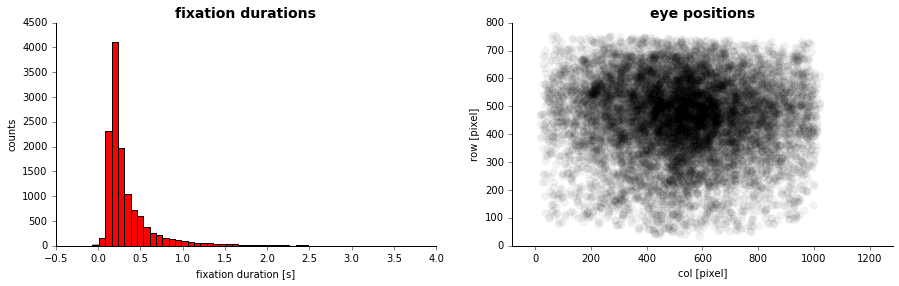

In [143]:
#hist of fixation durations
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.hist(features_nat_df['fix_duration'], 50, color='r');
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.xlabel('fixation duration [s]')
plt.ylabel('counts')
plt.title('fixation durations')

plt.subplot(122)
plt.plot(features_nat_df['col'], features_nat_df['row'], 'k.', ms=15, alpha=0.05);
plt.xlabel('col [pixel]')
plt.ylabel('row [pixel]')
plt.title('eye positions')
plt.axis('equal')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')

plt.show()


#### visual

In [28]:
# Extract a patch of arbitrary radius around a fixation and compute hue histograms. put these into a dataframe also
fixation_list = dd.io.load('fixation_list.h5')
Xnat = dd.io.load('Xnat.h5')
hue_nat_mean = dd.io.load('hue_nat_mean.h5')
hue_nat_kurt = dd.io.load('hue_nat_kurt.h5')
Xnat_shuf = dd.io.load('Xnat_shuf.h5')

## Explore data by visualizing PSTHs

This is done using the spykes package

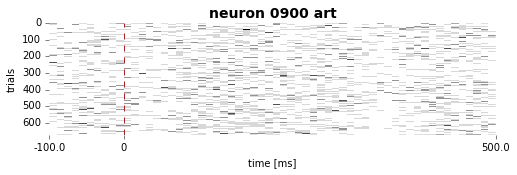

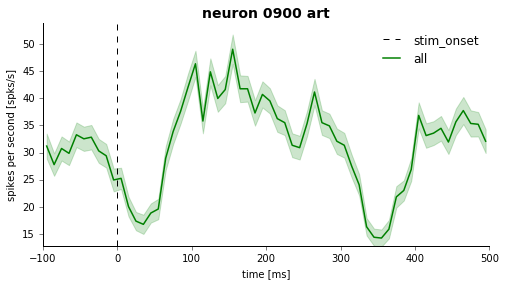

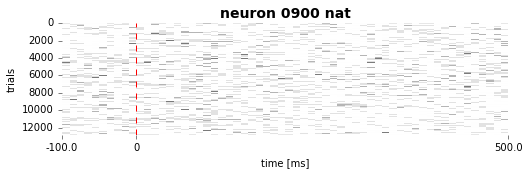

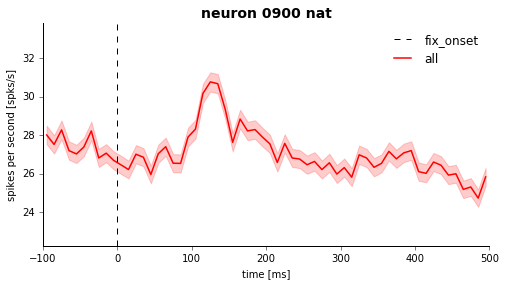

In [152]:
selected_neuron = '0900'
patch_choose = 14

params['selected_neuron'] = selected_neuron

neuron_id = params['selected_neuron']
art_neuron = NeuroVis(art_dat['spikes'][neuron_id], name='%s art' % neuron_id)
nat_neuron = NeuroVis(nat_dat['spikes'][neuron_id], name='%s nat' % neuron_id)

art_events = dict()
art_events['stim_onset'] = np.array([art_dat['eyes'][i]['stim_onset'] for i in art_dat['eyes']])

psth = art_neuron.get_raster(events=art_events['stim_onset']);
psth = art_neuron.get_psth(events=art_events['stim_onset'], plot=False);
art_neuron.plot_psth(psth=psth, event_name='stim_onset', colors='g');

nat_events = dict()
nat_events['fix_onset'] = np.array([nat_dat['eyes'][i]['fix_onset'] for i in nat_dat['eyes']])

psth = nat_neuron.get_raster(events=nat_events['fix_onset']);
psth = nat_neuron.get_psth(events=nat_events['fix_onset'], plot=False);
nat_neuron.plot_psth(psth=psth, event_name='fix_onset', colors='r');

## Get spike counts (Y)

We are goign to try to predict the expected number of spikes occuring 50ms to 300ms after fixation/stim onset

### artificial

In [146]:
# Get number of samples and neurons
n_samples = len(art_dat['events'])
n_neurons = len(art_dat['spikes'].keys())

# Initialize spikecounts vector
Yart = dict()
for neuron_id in art_dat['spikes'].keys():
    # Extract spiketimes for a given neuron
    spiketimes = art_dat['spikes'][neuron_id]
    
    # Extract spikecounts
    if len(spiketimes) > 1:
        neuron = NeuroVis(spiketimes, name=neuron_id)
        Yart[neuron_id] = neuron.get_spikecounts(features_art['onset_times'], window=params['window'])
    else:
        Yart[neuron_id] = np.zeros(n_samples)

### natural

In [147]:
features_nat = dict()
features_nat['valid_fix_onset'] = np.array([nat_dat['eyes'][i]['fix_onset'] for i in fixation_list])

In [149]:
# Initialize spikecounts vector
Ynat = dict()

# Only collect spikecounts for included fixations
n_samples = len(fixation_list)

neuron_id = params['selected_neuron']
# Extract spiketimes for a given neuron
spiketimes = nat_dat['spikes'][neuron_id]

if len(spiketimes) > 1:
    # Extract spikecounts
    neuron = NeuroVis(spiketimes, name=neuron_id)
    Ynat[neuron_id] = neuron.get_spikecounts(features_nat['valid_fix_onset'], window=params['window'])
else:
    Ynat[neuron_id] = np.zeros(n_samples)

In [150]:
selected_neuron = params['selected_neuron']
print "Xart (%d, %d); Yart (%d,)" % (np.shape(Xart)[0], np.shape(Xart)[1], np.shape(Yart[selected_neuron])[0])
print "Xnat (%d, %d); Ynat (%d,)" % (np.shape(Xnat[0])[0], np.shape(Xnat[0])[1], np.shape(Ynat[selected_neuron])[0])

Xart (673, 16); Yart (673,)
Xnat (7575, 16); Ynat (7575,)


## Model fitting

### Artificial

In [153]:
Yt_art_hat, PR2_art = V4pyutils.fit_cv(Xart, Yart[selected_neuron], algorithm = 'XGB_poisson', verbose = 1)

pR2_cv: 0.380907 (+/- 0.018531)


In [154]:
Models_art = dict()
Models_art['hue'] = dict()
Models_art['hue']['covariates'] = ['hue']

Models_art['Joint'] = dict()
Models_art['Joint']['covariates'] = ['hue', 'off_to_onset_times', 'onset_times']


for i, model in enumerate(Models_art):
    print 'running model %d of %d: %s' % (i+1, len(Models_art), model)
    X = features_art_df[Models_art[model]['covariates']].values
    Yt_hat, PR2 = V4pyutils.fit_cv(X, Yart[selected_neuron], 
                                       algorithm='XGB_poisson', 
                                       verbose=1)
    
    Models_art[model]['Yt_hat'], Models_art[model]['PR2'] = Yt_hat, PR2    
    print ''

running model 1 of 2: hue
pR2_cv: 0.423378 (+/- 0.017590)

running model 2 of 2: Joint
pR2_cv: 0.439096 (+/- 0.019927)



## Hue is an angle

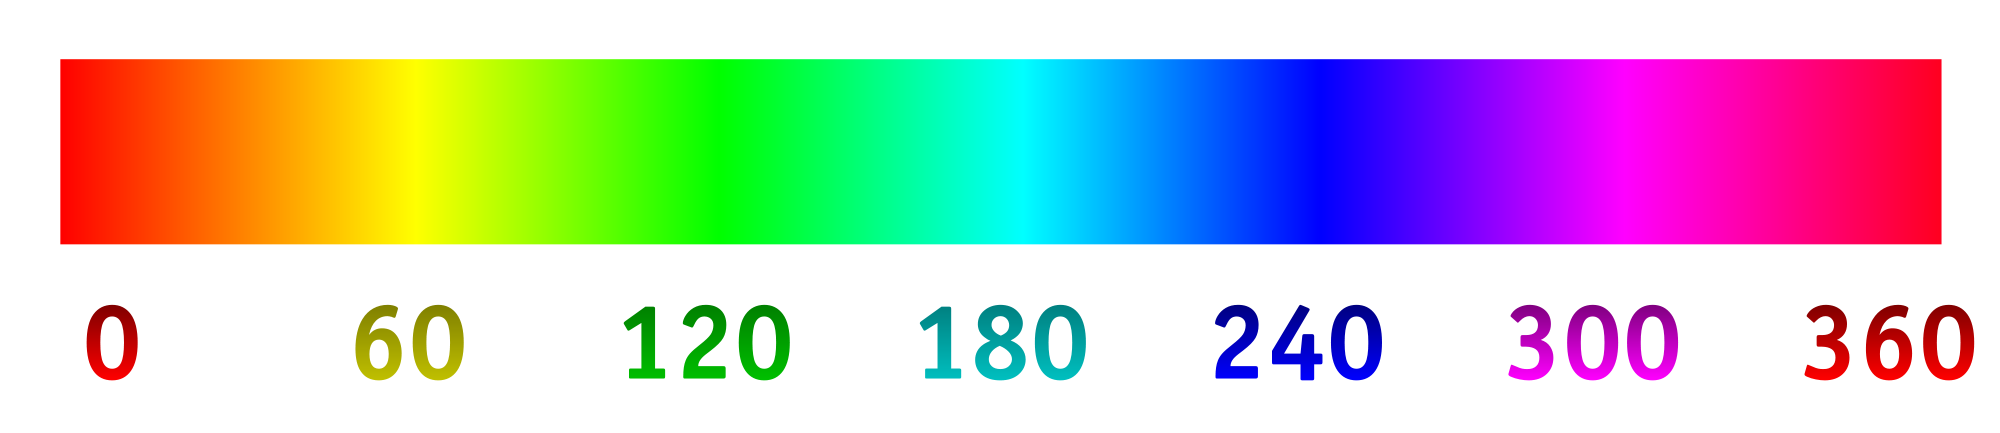

In [155]:
Image(filename="../Figures/2000px-HueScale.svg.png", width=300)

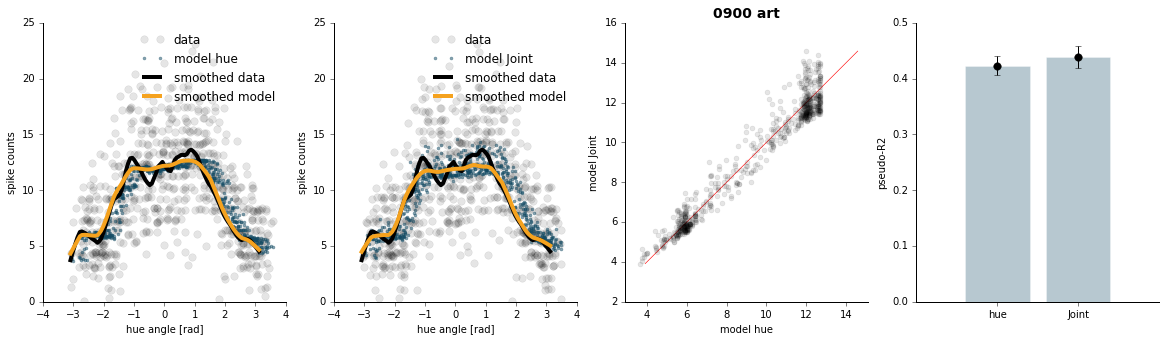

In [156]:
x_variable = features_art_df['hue']
y_counts = Yart[selected_neuron]
xlabel='hue angle [rad]'
model = 'hue'
plt.figure(figsize=(20,5))
plt.subplot(141)
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_art, 
                             model=model, lowess_frac = 0.1, xlabel=xlabel, xnoise=0.5, 
                             model_alpha=0.5, colors=[color_model_art, color_data_art], data_ms=15)
plt.subplot(142)
model = 'Joint'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_art, 
                             model=model, lowess_frac = 0.1, xlabel=xlabel, xnoise=0.5, 
                             model_alpha=0.5, colors=[color_model_art, color_data_art], data_ms=15)

plt.subplot(143)
models_for_plot = ['hue','Joint']
title = '%s art' % params['selected_neuron']
V4pyutils.plot_model_vs_model(models_for_plot=models_for_plot, models=Models_art, title=title)

plt.subplot(144)
models_for_plot = ['hue', 'Joint']
V4pyutils.plot_model_comparison(models_for_plot, models=Models_art, color=[color_data_art])

Observations:
- looking at the smoothed model the fit seems actually worse, could be because lowess is not taking into account that hue is a circular variable? ir just because looking at smoothed version might not be a good way to look at goodness of fit
- compute relative pseudoR2
- smoothed data and fit seem to have a slight offset 

### Natural

- In the future we will use CNNs to extract features automatically, initially with transfer learning and later one training the whole or part of the network
- Right now we started by feature engineering: 

#### for each fixation we consider a region around eye position

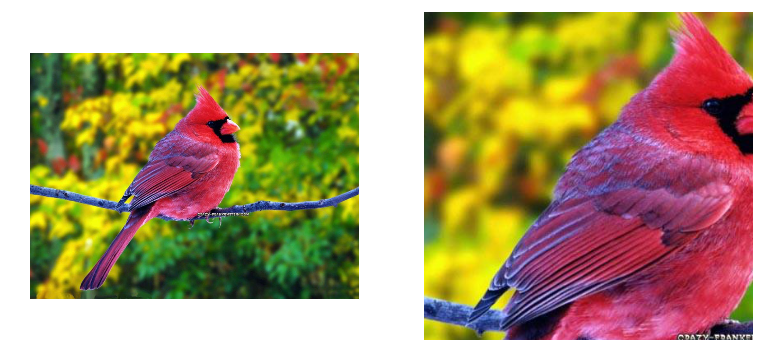

In [75]:
Image(filename="../Figures/image_and_patch.png", width=500)

#### then grid it

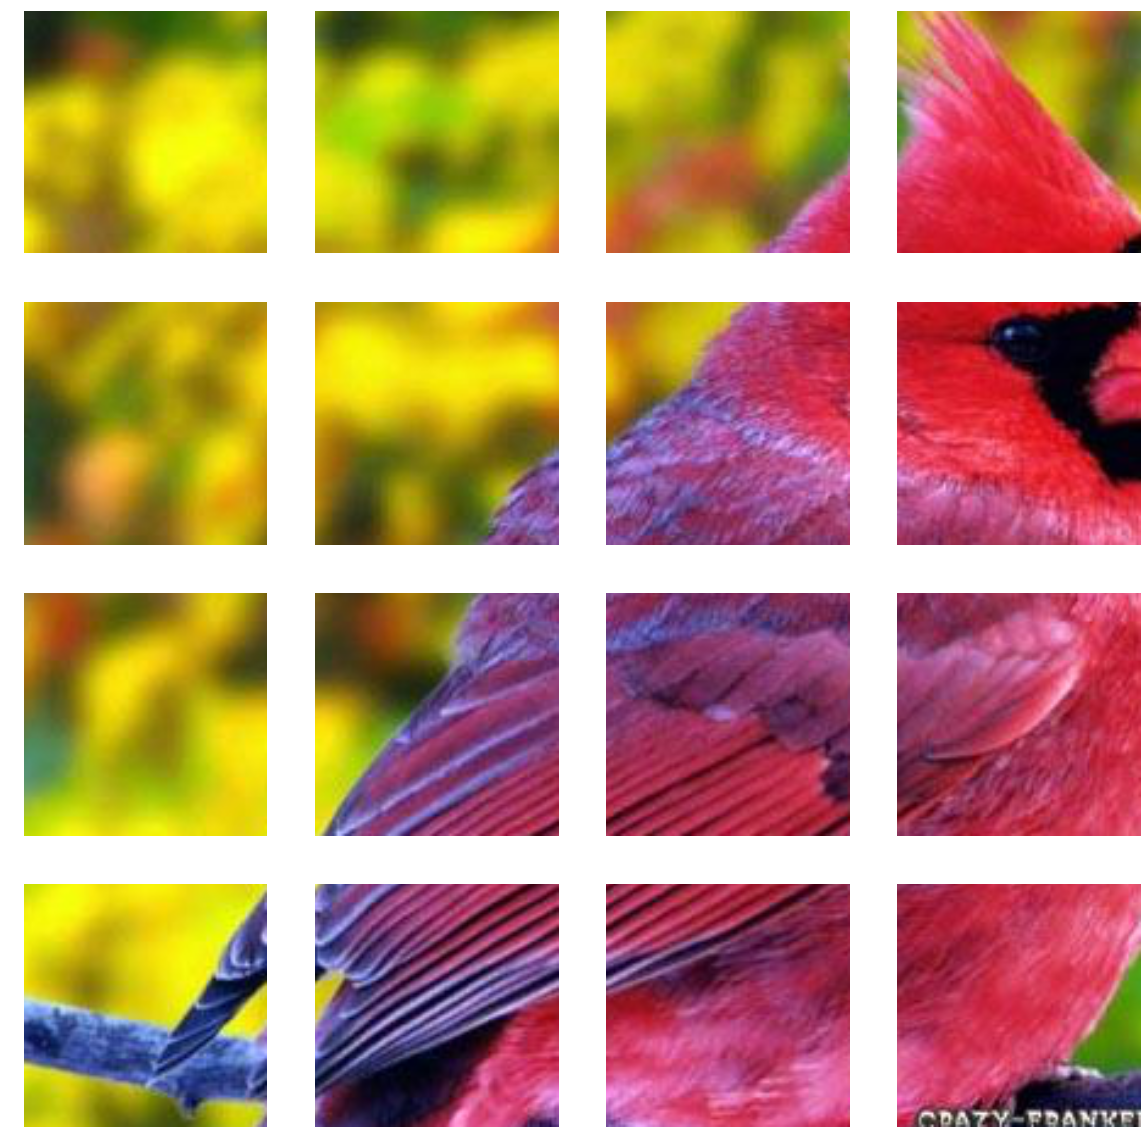

In [78]:
Image(filename="../Figures/grid_image.png", width=300)

#### and we start by using the hue histograms of each patch as features

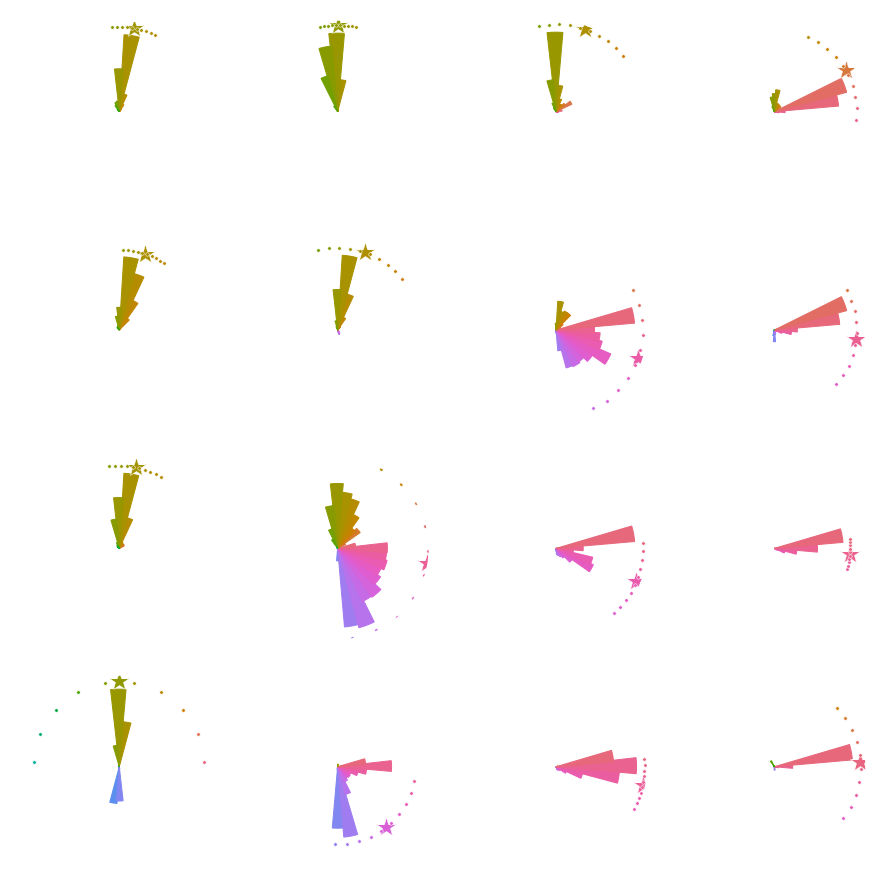

In [157]:
Image(filename="../Figures/grid_hist.png", width=300)

### we get significant prediction

In [159]:
Yt_nat_hat = dict()
PR2_nat = dict()
for patch_n in np.arange(params['n_patches']):
    Yt_nat_hat[patch_n], PR2_nat[patch_n] = V4pyutils.fit_cv(Xnat[patch_n], 
                                                             Ynat[selected_neuron], 
                                                             algorithm = 'XGB_poisson',
                                                             label=[features_nat_df['trial'][fixation_list]],
                                                             n_cv=10,
                                                             verbose = 1) 

pR2_cv: 0.004688 (+/- 0.002642)
pR2_cv: 0.006078 (+/- 0.002734)
pR2_cv: 0.006265 (+/- 0.003737)
pR2_cv: 0.004922 (+/- 0.003871)
pR2_cv: 0.011575 (+/- 0.002921)
pR2_cv: 0.012767 (+/- 0.004203)
pR2_cv: 0.009101 (+/- 0.005318)
pR2_cv: 0.005217 (+/- 0.003065)
pR2_cv: 0.009468 (+/- 0.003161)
pR2_cv: 0.022225 (+/- 0.005090)
pR2_cv: 0.033881 (+/- 0.005357)
pR2_cv: 0.015557 (+/- 0.003813)
pR2_cv: 0.017869 (+/- 0.002575)
pR2_cv: 0.039544 (+/- 0.002501)
pR2_cv: 0.063962 (+/- 0.003986)
pR2_cv: 0.041604 (+/- 0.005220)


### but not when we shuffle the images, good!

In [160]:
Yt_nat_hat_shuf = dict()
PR2_nat_shuf = dict()
for patch_n in np.arange(params['n_patches']):
    Yt_nat_hat_shuf[patch_n], PR2_nat_shuf[patch_n] = V4pyutils.fit_cv(Xnat_shuf[patch_n], 
                                                                       Ynat[selected_neuron], 
                                                                       algorithm = 'XGB_poisson',
                                                                       label=[features_nat_df['trial'][fixation_list]],
                                                                       n_cv=10,
                                                                       verbose = 1) 

pR2_cv: -0.004715 (+/- 0.002332)
pR2_cv: -0.008531 (+/- 0.001804)
pR2_cv: -0.004153 (+/- 0.001785)
pR2_cv: -0.009133 (+/- 0.002050)
pR2_cv: -0.004738 (+/- 0.002124)
pR2_cv: -0.001630 (+/- 0.002133)
pR2_cv: -0.006530 (+/- 0.002227)
pR2_cv: -0.006587 (+/- 0.001660)
pR2_cv: -0.002065 (+/- 0.001436)
pR2_cv: -0.005432 (+/- 0.001891)
pR2_cv: -0.004758 (+/- 0.002125)
pR2_cv: -0.006881 (+/- 0.002097)
pR2_cv: -0.007010 (+/- 0.002071)
pR2_cv: -0.005547 (+/- 0.002389)
pR2_cv: -0.003652 (+/- 0.002846)
pR2_cv: -0.006593 (+/- 0.002809)


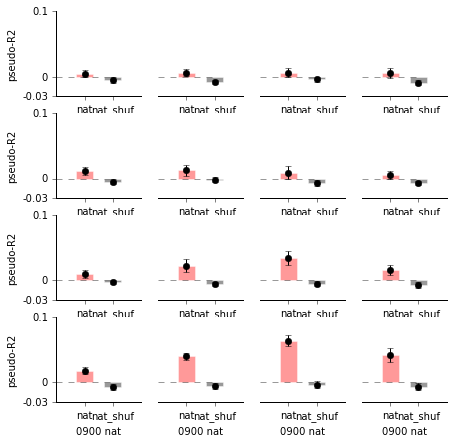

In [161]:
plt.figure(figsize=(7,7))
plt.title('neuron %s' % selected_neuron)
ylim = [-0.03,0.1]
for patch_n in PR2_nat:
    mean_pR2 = np.mean(PR2_nat[patch_n])
    sem_pR2 = np.std(PR2_nat[patch_n])/np.sqrt(np.size(PR2_nat[patch_n]))
    mean_pR2_shuf = np.mean(PR2_nat_shuf[patch_n])
    sem_pR2_shuf = np.std(PR2_nat_shuf[patch_n])/np.sqrt(np.size(PR2_nat_shuf[patch_n]))

    plt.subplot(4,4,patch_n+1)

    plt.bar([0,1], [mean_pR2, mean_pR2_shuf], 0.6, align='center', 
            ecolor='k', alpha=0.4, color=['r','k'], ec='w', yerr=1.96*np.array([sem_pR2, sem_pR2_shuf]), 
            tick_label=['nat','nat_shuf'])
    
    plt.plot([-1,1],[0,0],'--k', alpha=0.4)
    plt.plot([0,1], [mean_pR2, mean_pR2_shuf], '.', c='k', markersize=13)
    plt.xlim([-1,2])
   
    plt.ylim(ylim)
    
    ax = plt.gca()
    
    if patch_n>11:
        plt.xlabel(nat_neuron.name)
    if patch_n%4==0:
        plt.ylabel('pseudo-R2')
        plt.yticks([ylim[0],0,ylim[1]],[ylim[0],'0',ylim[1]])
    if patch_n%4>0:
        ax.spines['left'].set_visible(False)
        plt.yticks(ylim,['',''])
        plt.tick_params(axis='y', left='off')
     
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')

plt.show()

### Let's include non-image features
#### for best looking patch 14
this a bit of double dipping but we are exploring, later on this should be done within the traingin set

running model 1 of 6: M1
running model 2 of 6: M1_c
running model 3 of 6: M2
running model 4 of 6: M2_c
running model 5 of 6: M3
running model 6 of 6: M3_c


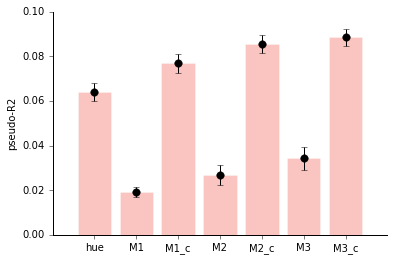

In [162]:
# choose models  

Models_nat = dict()
Models_nat['M1'] = dict()
Models_nat['M1']['covariates'] = ['col','row']
Models_nat['M1_c'] = dict()
Models_nat['M1_c']['covariates'] = Models_nat['M1']['covariates']

Models_nat['M2'] = dict()
Models_nat['M2']['covariates'] = ['col','row','trial']
Models_nat['M2_c'] = dict()
Models_nat['M2_c']['covariates'] = Models_nat['M2']['covariates']

Models_nat['M3'] = dict()
Models_nat['M3_c'] = dict()
Models_nat['M3']['covariates'] = ['col','row','trial','fixation', 
                                  'out_sac_blink', 'in_sac_dur', 'fix_duration', 'prev_fix_duration', 'drift', 
                                  'out_sac_dur', 'next_fix_duration']
Models_nat['M3_c']['covariates'] = Models_nat['M3']['covariates']


# --------------------------------------------------------------------------
# fit models

for i, model in enumerate(sorted(Models_nat.keys())):
    print 'running model %d of %d: %s' % (i+1, len(Models_nat), model)
    
    X = features_nat_df[Models_nat[model]['covariates']].values[fixation_list]
    if model[-2:] == '_c':
        X = np.concatenate((X, Xnat[patch_choose]), axis=1)
        
    Yt_hat, PR2 = V4pyutils.fit_cv(X, Ynat[selected_neuron], 
                                       algorithm='XGB_poisson',
                                       label=[features_nat_df['trial'][fixation_list]],
                                       verbose=0)
    
    Models_nat[model]['Yt_hat'], Models_nat[model]['PR2'] = Yt_hat, PR2
    
    X = features_nat_df[Models_nat[model]['covariates']].values[fixation_list]
    if model[-2:] == '_c':
        #print 'shuffle control:'
        X = np.concatenate((X, Xnat_shuf[patch_choose]), axis=1)
        
        Yt_hat, PR2 = V4pyutils.fit_cv(X, Ynat[selected_neuron], 
                                           algorithm='XGB_poisson',
                                           label=[features_nat_df['trial'][fixation_list]],
                                           verbose=0)
        Models_nat[model]['Yt_hat_shuf'], Models_nat[model]['PR2_shuf'] = Yt_hat, PR2
    
    #print '' 
    
Models_nat['hue'] = dict()
Models_nat['hue']['Yt_hat'], Models_nat['hue']['PR2'] = Yt_nat_hat[patch_choose], PR2_nat[patch_choose]

# --------------------------------------------------------------------------
# plot
models_for_plot = ['hue','M1', 'M1_c', 'M2', 'M2_c', 'M3', 'M3_c']
V4pyutils.plot_model_comparison(models_for_plot, models=Models_nat, color=[color_data_nat])

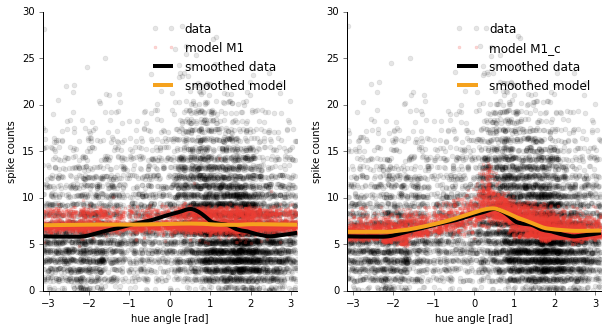

In [163]:
# how does hue tuning looks like
plt.figure(figsize=(10, 5))

plt.subplot(121)
model='M1'
x_variable = np.arctan2(np.sin(hue_nat_mean[patch_choose]), np.cos(hue_nat_mean[patch_choose]))
y_counts = Ynat[selected_neuron]
xlabel='hue angle [rad]'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat,
                             model=model, lowess_frac = 0.2, xlabel=xlabel, xnoise=0, 
                             ynoise=0.5, model_alpha=0.2)
plt.xlim([-np.pi, np.pi])

plt.subplot(122)
model='M1_c'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                             model=model, lowess_frac = 0.2, xlabel=xlabel, xnoise=0, 
                             ynoise=0.5, model_alpha=0.2)
plt.xlim([-np.pi, np.pi])

plt.show()

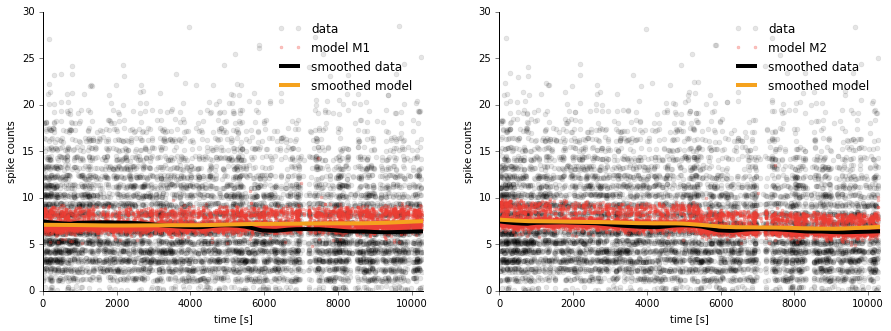

In [164]:
#why such big increase from M1 to M2? because of trial number.
#when doing model comparison maybe it's better to do use the model with trial number as covariate as a baseline 
#model instead of the homogeneous
plt.figure(figsize=(15, 5))
plt.subplot(121)
model='M1'
x_variable = features_nat_df['fix_onset'][fixation_list]
y_counts = Ynat[selected_neuron]
xlabel='time [s]'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.2, xlabel=xlabel, xnoise=0.5,
                   model_alpha=0.3)
plt.xlim([0,x_variable.values[-1]])

plt.subplot(122)
model='M2'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.2, xlabel=xlabel, xnoise=0.5,
                   model_alpha=0.3)
plt.xlim([0,x_variable.values[-1]])
plt.show()

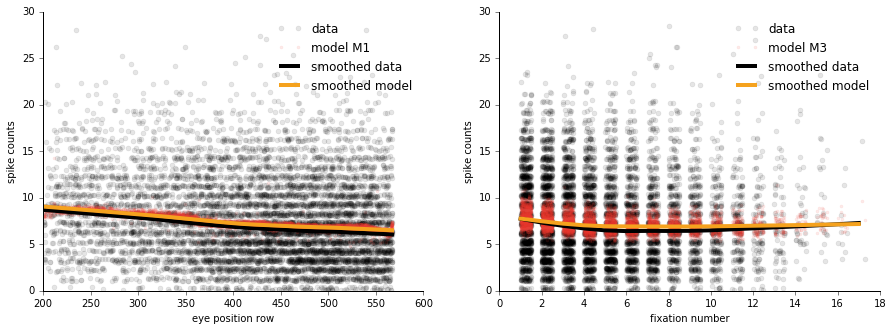

In [165]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
model='M1'
x_variable = features_nat_df['row'][fixation_list]
y_counts = Ynat[selected_neuron]
xlabel='eye position row'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.5, xlabel=xlabel, xnoise=0.5, ynoise=0.5)

plt.subplot(122)
model='M3'
x_variable = features_nat_df['fixation'][fixation_list]
y_counts = Ynat[selected_neuron]
xlabel='fixation number'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.5, xlabel=xlabel, xnoise=0.5, ynoise=0.5)

plt.show()

# Synthetic NeuroPhys

In [166]:
hue_line = np.linspace(-np.pi, np.pi, 16)
Xart_line = V4pyutils.onehothue(hue_line, n_bins=16)

X = features_nat_df[Models_nat['M1']['covariates']].values[fixation_list]

# get convariates train
XXr = np.concatenate((X, Xnat[patch_choose]), axis=1)
XXr_shuf = np.concatenate((X, Xnat_shuf[patch_choose]), axis=1)

#get convariates test: repmat the image features and 
n_repeats = 1000
Xart_line_rep = np.matlib.repmat(Xart_line, n_repeats, 1)
hue_line_rep = np.matlib.repmat(hue_line, 1, n_repeats)
#sample the non-image features
idx = np.random.randint(0, np.shape(X)[0], size=np.shape(Xart_line_rep)[0])
XXt = X[idx,:]
XXt = np.concatenate((XXt, Xart_line_rep), axis=1)

# learn synthetic neuron and predict for artificial
Yline_nat_hat = V4pyutils.XGB_poisson(XXr, Ynat[selected_neuron], XXt)
Yline_nat_shuf_hat = V4pyutils.XGB_poisson(XXr_shuf, Ynat[selected_neuron], XXt)
Yline_art_hat = V4pyutils.XGB_poisson(Xart, Yart[selected_neuron], Xart_line)

In [167]:
meanYt = list()
stdYt = list()
meanYtshuf = list()
stdYtshuf = list()
for i in np.unique(hue_line_rep):
    loc = np.where(hue_line_rep==i)[1]
    meanYt.append(np.mean(Yline_nat_hat[loc]))
    stdYt.append(np.std(Yline_nat_hat[loc]))
    meanYtshuf.append(np.mean(Yline_nat_shuf_hat[loc]))
    stdYtshuf.append(np.std(Yline_nat_shuf_hat[loc]))

meanYt = np.array(meanYt)
stdYt = np.array(stdYt)
meanYtshuf = np.array(meanYtshuf)
stdYtshuf = np.array(stdYtshuf)

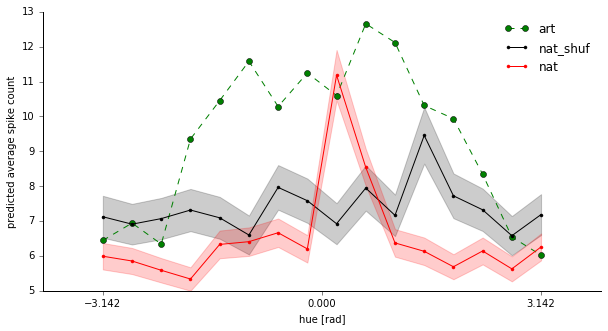

In [168]:
plt.figure(figsize=(10,5))
plt.plot(hue_line, Yline_art_hat,'o--g')

plt.plot(hue_line, meanYtshuf, '-k.')
plt.fill_between(hue_line, meanYtshuf-stdYtshuf, meanYtshuf+stdYtshuf, color='k', alpha=0.2)

plt.plot(hue_line, meanYt, '-r.')
plt.fill_between(hue_line, meanYt-stdYt, meanYt+stdYt, color='r', alpha=0.2)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.ylabel('predicted average spike count')
plt.xlabel('hue [rad]')
plt.xticks(np.linspace(-np.pi,np.pi,3))
plt.legend(['art', 'nat_shuf', 'nat'],frameon= False, loc=0)
plt.show()

### Plot dashboard

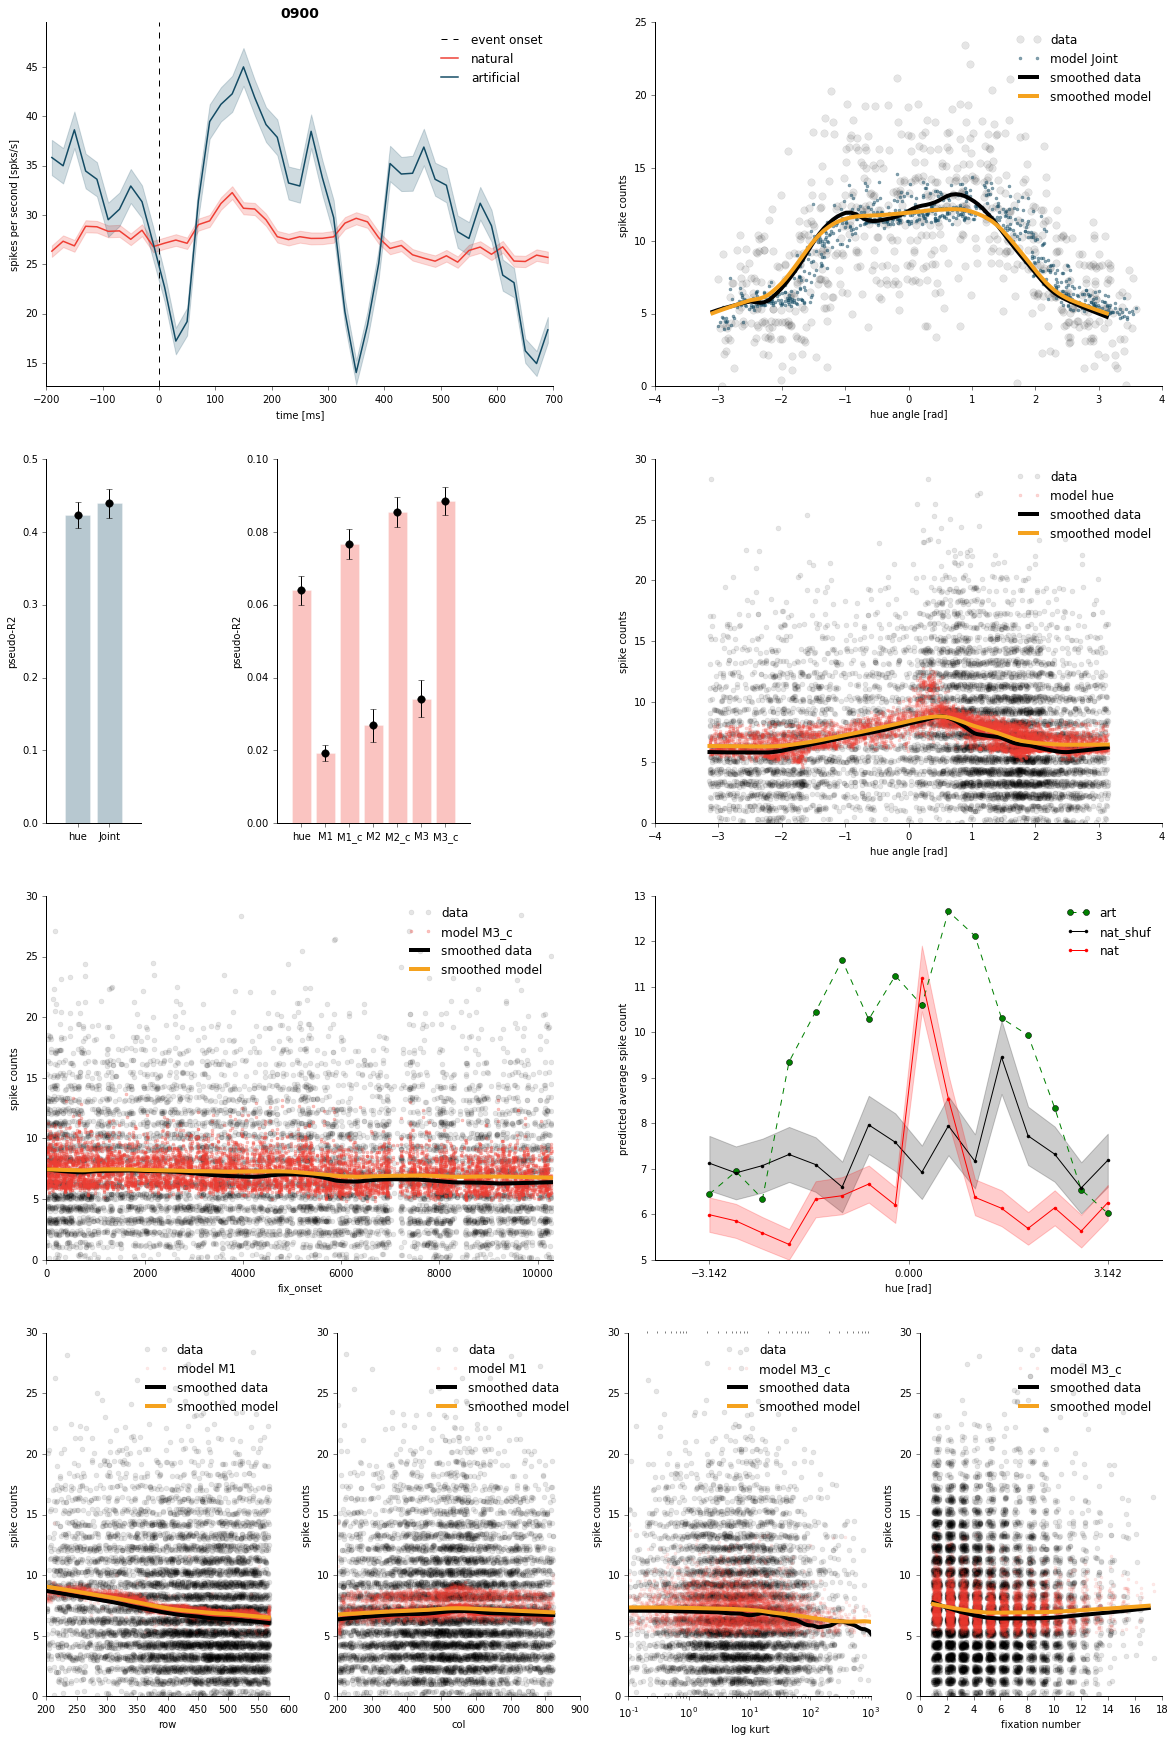

In [169]:
title=art_neuron.name[:-4]
color_data_art = colors[1]
color_data_nat = colors[2]
color_model_art = colors[0]
color_model_nat = colors[0]

models_for_plot = ['hue','Joint']
model_nat = 'M3_c'

# --------------------------------------------------------------
#get psths
#artificial
conditions = dict()

cond = 0
conditions[cond]= dict()
conditions[cond]['stim_dur'] = [0.1, 0.2]

psth_art = art_neuron.get_psth(features_art_df['onset_times'], 
                               features_art_df, conditions, 
                               window=[-200,700], binsize=20, plot=False);

#natural
conditions = dict()
cond = 0
conditions[cond]= dict()
conditions[cond]['fix_duration'] = [0.1, 0.2] 

psth_nat = nat_neuron.get_psth(features_nat_df['fix_onset'], 
                               features_nat_df, conditions, window=[-200,700], 
                               binsize=20, plot=False);

psth = psth_nat
psth['conditions'][1] = psth_art['conditions'][0] 
psth['data'][1] = dict()
psth['data'][1]['mean'] = psth_art['data'][0]['mean']
psth['data'][1]['sem'] = psth_art['data'][0]['sem']

# ---------------------------------------------------------------

plt.figure(figsize=(20,30))
plt.title(title)

plt.subplot(421)
V4pyutils.plot_psth(psth, condition_names=['natural', 'artificial'], colors=[color_data_nat, color_data_art], 
                    event_name='event onset')
plt.title(title)


plt.subplot(422)
model='Joint'
x_variable = features_art_df['hue']
y_counts = Yart[selected_neuron]
xlabel='hue angle [rad]'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_art, 
                             model=model, lowess_frac = 0.2, xlabel=xlabel, xnoise=0.5, 
                             model_alpha=0.5, colors=[color_model_art, color_data_art], data_ms=15)


plt.subplot(4,10,11)
V4pyutils.plot_model_comparison(models_for_plot, models=Models_art, color=[color_data_art])


plt.subplot(4,5,7)
models_for_plot = ['hue','M1', 'M1_c', 'M2', 'M2_c', 'M3', 'M3_c']
V4pyutils.plot_model_comparison(models_for_plot, models=Models_nat, color=[color_data_nat])


plt.subplot(4,2,4)
model='hue'
x_variable =np.arctan2(np.sin(hue_nat_mean[patch_choose]), np.cos(hue_nat_mean[patch_choose]))
y_counts = Ynat[selected_neuron]
xlabel='hue angle [rad]'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.2, xlabel=xlabel, xnoise=0, ynoise=0.5, model_alpha=0.2)


plt.subplot(425)
model='M3_c'
x_variable = features_nat_df['fix_onset'][fixation_list]
y_counts = Ynat[selected_neuron]
xlabel='fix_onset'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.2, xlabel=xlabel, xnoise=0.5,
                   model_alpha=0.3)
plt.xlim([0,x_variable.values[-1]])

#-----------------------------------------------------------
plt.subplot(426)
plt.plot(hue_line, Yline_art_hat,'o--g')

plt.plot(hue_line, meanYtshuf, '-k.')
plt.fill_between(hue_line, meanYtshuf-stdYtshuf, meanYtshuf+stdYtshuf, color='k', alpha=0.2)

plt.plot(hue_line, meanYt, '-r.')
plt.fill_between(hue_line, meanYt-stdYt, meanYt+stdYt, color='r', alpha=0.2)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.ylabel('predicted average spike count')
plt.xlabel('hue [rad]')
plt.xticks(np.linspace(-np.pi,np.pi,3))
plt.legend(['art', 'nat_shuf', 'nat'],frameon= False, loc=0)
#----------------------------------------------------------

plt.subplot(4,4,13)
model='M1'
x_variable = features_nat_df['row'][fixation_list]
y_counts = Ynat[selected_neuron]
xlabel='row'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.5, xlabel=xlabel, xnoise=0.5)


plt.subplot(4,4,14)
model='M1'
x_variable = features_nat_df['col'][fixation_list]
y_counts = Ynat[selected_neuron]
xlabel='col'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.5, xlabel=xlabel, xnoise=0.5)


plt.subplot(4,4,15)
model='M3_c'
x_variable = hue_nat_kurt[patch_choose]
y_counts = Ynat[selected_neuron]
xlabel='log kurt'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.5, xlabel=xlabel, xnoise=0.5, ynoise=0.5,
                   semilogx=True)
plt.xlim([10e-2, 10e2])

plt.subplot(4,4,16)
model='M3_c'
x_variable = features_nat_df['fixation'][fixation_list]
y_counts = Ynat[selected_neuron]
xlabel='fixation number'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.5, xlabel=xlabel, xnoise=0.5, ynoise=0.5)

#plt.savefig('dash_board_%s.jpg' % nat_neuron.name[:-4])
#plt.savefig('dash_board_%s.pdf' % nat_neuron.name[:-4])
plt.show()